<a href="https://colab.research.google.com/github/ReemGhazi0/AnalysisProject/blob/main/fakenews2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
news_d = pd.read_csv("train.csv")
news_d.shape

(20800, 5)

In [ ]:
print(news_d.isna().sum())
test_d.dropna(inplace=True)
id_ = test_d.id

id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [ ]:
news_d.head(10)

id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                         author  \
0                 Darrell Lucus   
1               Daniel J. Flynn   
2            Consortiumnews.com   
3               Jessica Purkiss   
4                Howard Portnoy   
5               Daniel Nussbaum   
6                           NaN   
7               Alissa J. Rubin   
8                           NaN   
9  Megan Twohey and Scott Shane   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  
5  In these trying times, Jackie Mason is the Voi...      0  
6  Ever wonder how Britain’s most iconic pop pian...      1  
7  PARIS  —   France chose an idealistic, traditi...      0  
8  Donald J. Trump is scheduled to make a highly ...      0  
9  A week before Michael T. Flynn resigned as nat...      0

In [ ]:
txt_length = news_d.text.str.split().str.len()
txt_length.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [ ]:
#Title statistics

title_length = news_d.title.str.split().str.len()
title_length.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

The statistics for the training and testing sets are as follows:

The text attribute has a higher word count with an average of 760 words and 75% having more than 1000 words.
The title attribute is a short statement with an average of 12 words, and 75% of them are around 15 words.
Our experiment would be with both text and title together.

Distribution of Classes
Counting plots for both labels:


1: Unreliable
0: Reliable
Distribution of labels:
label
1    10413
0    10387
Name: count, dtype: int64


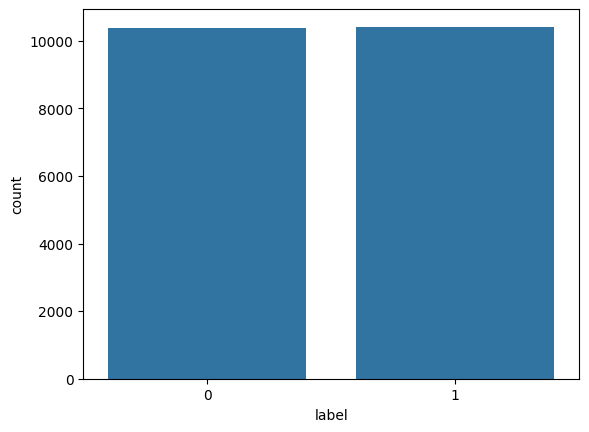

In [ ]:
sns.countplot(x="label", data=news_d);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_d.label.value_counts());


Data Cleaning for Analysis


In [ ]:
# Constants that are used to sanitize the datasets

column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

In [ ]:
import nltk #NLP
# Download the 'stopwords' resource before importing and using it
nltk.download('stopwords')  # This will download the stopwords dataset.
# Download the 'wordnet' resource.
nltk.download('wordnet')  # This will download the wordnet dataset, resolving the LookupError.
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


We have imported NLTK, which is a famous platform for developing Python applications that interact with human language. Next, we import re for regex.
We import stopwords from nltk.corpus. When working with words, particularly when considering semantics, we sometimes need to eliminate common words that do not add any significant meaning to a statement, such as "but", "can", "we", etc.
PorterStemmer is used to perform stemming words with NLTK. Stemmers strip words of their morphological affixes, leaving the word stem solely.
We import WordNetLemmatizer() from NLTK library for lemmatization. Lemmatization is much more effective than stemming. It goes beyond word reduction and evaluates a language's whole lexicon to apply morphological analysis to words, with the goal of just removing inflectional ends and returning the base or dictionary form of a word, known as the lemma.
stopwords.words('english') allow us to look at the list of all the English stop words supported by NLTK.
remove_unused_c() function is used to remove the unused columns.
We impute null values with None using the null_process() function.
Inside the function clean_dataset(), we call remove_unused_c() and null_process() functions. This function is responsible for data cleaning.
To clean text from unused characters, we have created the clean_text() function.
For preprocessing, we will use only stop word removal. We created the nltk_preprocess() function for that purpose.


In [ ]:
ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

# Now you can use stopwords.words('english') without errors
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)



# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [ ]:
#Preprocessing the text and title:

# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["text"] = df.text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
df["title"] = df.title.apply(nltk_preprocess)


In [ ]:
# Dataset after cleaning and preprocessing step
df.head(10)

title  \
0  house dem aide didnt even see comeys letter ja...   
1   flynn hillary clinton big woman campus breitbart   
2                              truth might get fired   
3   15 civilian killed single u airstrike identified   
4  iranian woman jailed fictional unpublished sto...   
5  jackie mason hollywood would love trump bombed...   
6  life life luxury elton john 6 favorite shark p...   
7  benoît hamon win french socialist party presid...   
8  excerpt draft script donald trump qampa black ...   
9  backchannel plan ukraine russia courtesy trump...   

                                                text  label  
0  house dem aide didnt even see comeys letter ja...      1  
1  ever get feeling life circle roundabout rather...      0  
2  truth might get fired october 29 2016 tension ...      1  
3  video 15 civilian killed single u airstrike id...      1  
4  print iranian woman sentenced six year prison ...      1  
5  trying time jackie mason voice reason week exc...      0  
6  ever wonder britain iconic pop pianist get lon...      1  
7  paris france chose idealistic traditional cand...      0  
8  donald j trump scheduled make highly anticipat...      0  
9  week michael flynn resigned national security ...      0

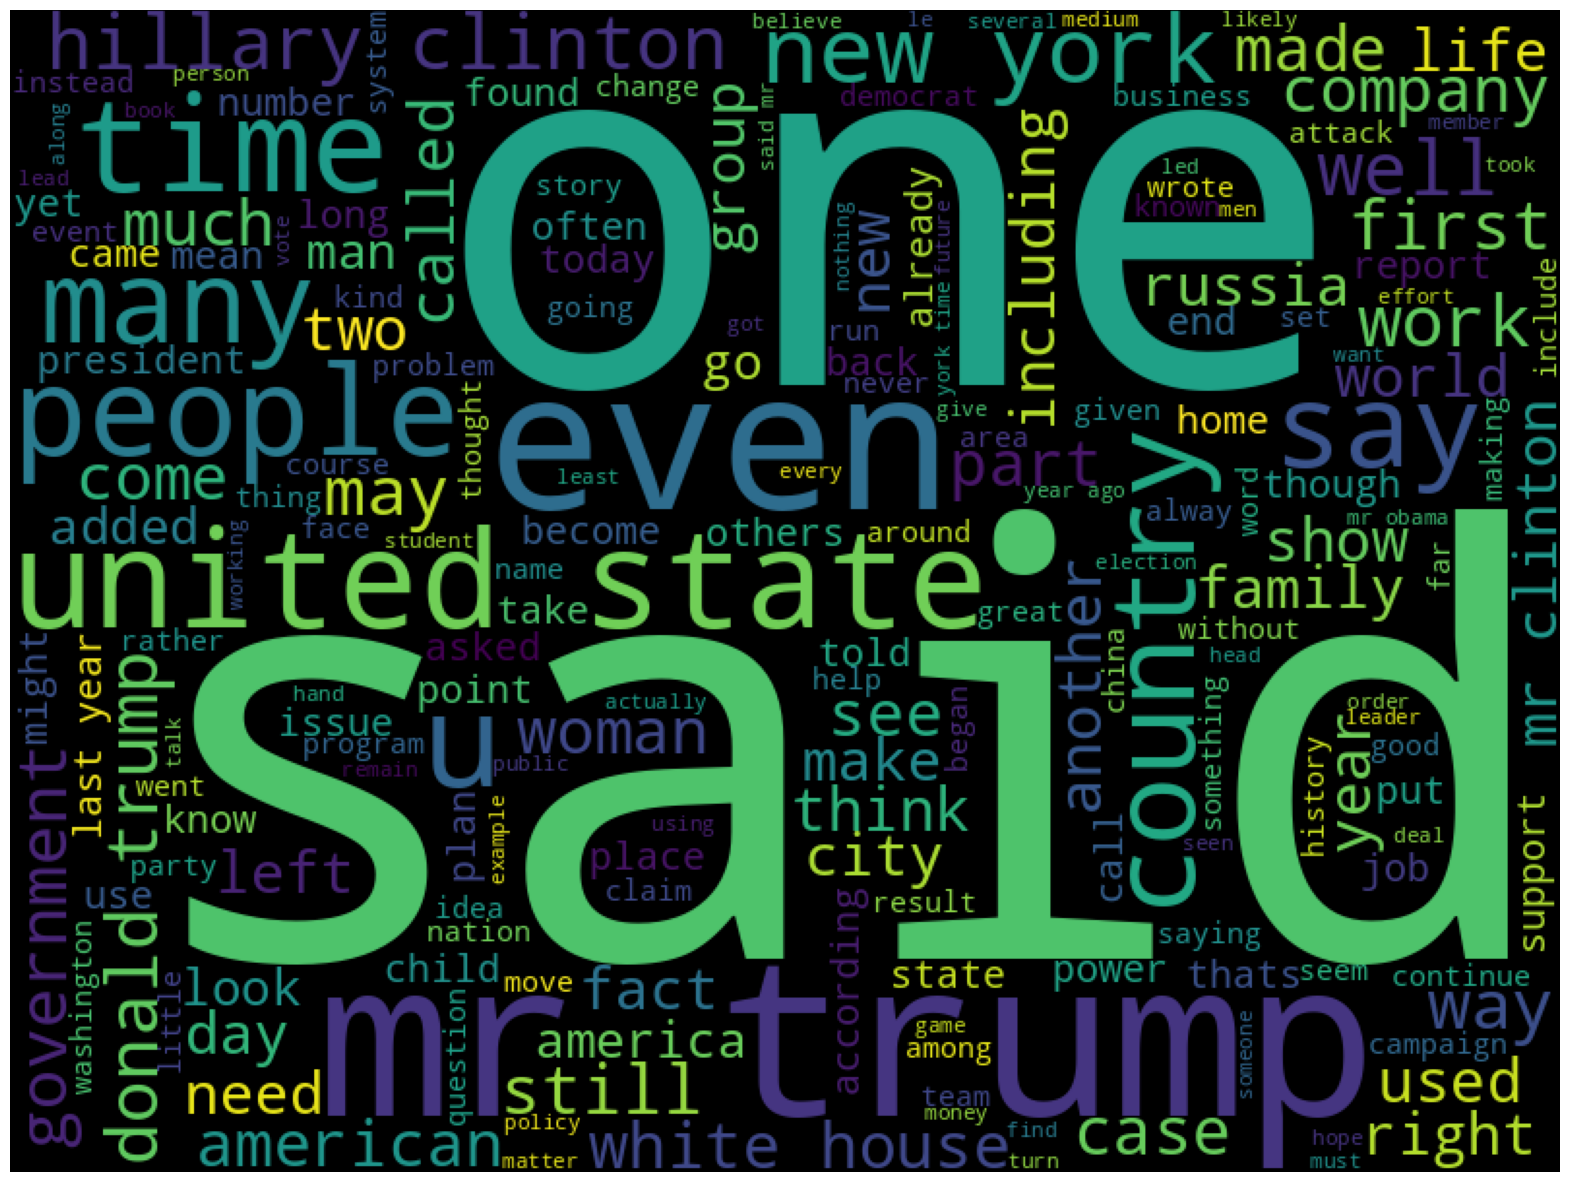

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# initialize the word cloud
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(df['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

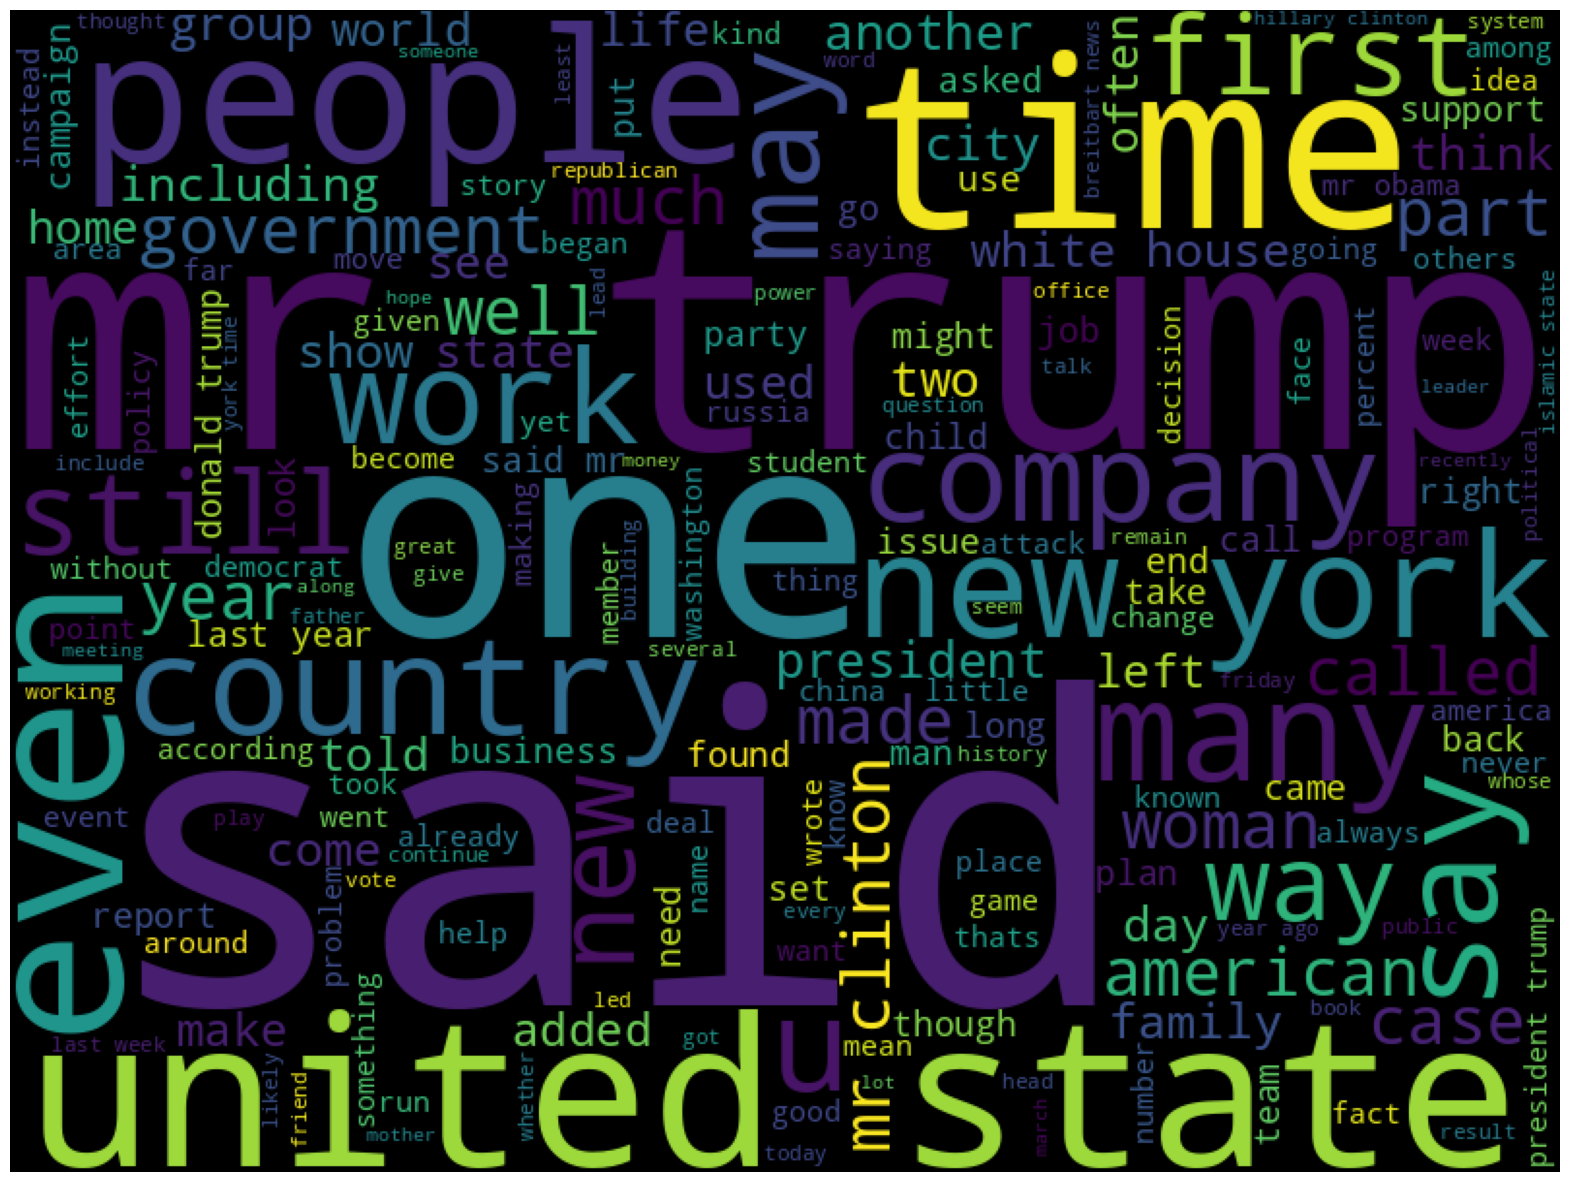

In [ ]:
#Word cloud for reliable news only:
true_n = ' '.join(df[df['label']==0]['text'])
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

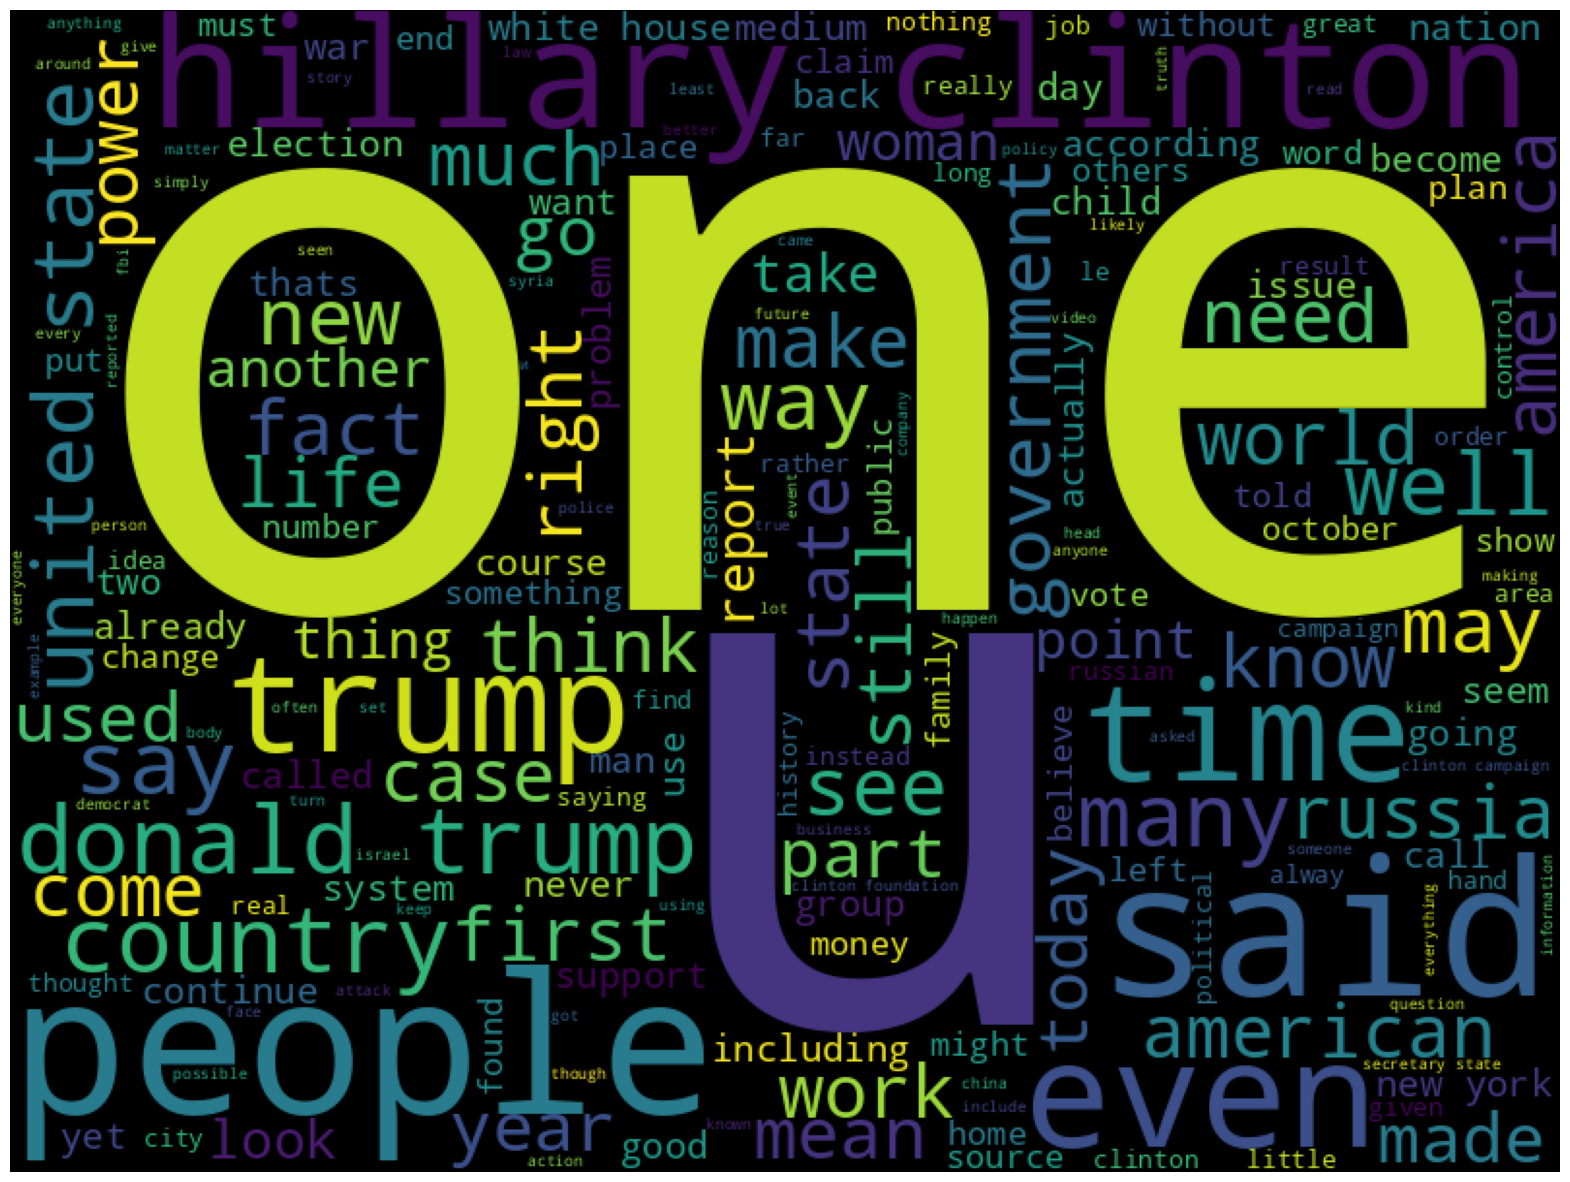

In [ ]:
#Word cloud for fake news only:
fake_n = ' '.join(df[df['label']==1]['text'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Assuming you want to create a DataFrame from the existing variable 'df'
dt = pd.DataFrame(df)  # Replace 'dt' with the data source you intend to use
dt['label'] = df['label']
dt

title  \
0      house dem aide didnt even see comeys letter ja...   
1       flynn hillary clinton big woman campus breitbart   
2                                  truth might get fired   
3       15 civilian killed single u airstrike identified   
4      iranian woman jailed fictional unpublished sto...   
...                                                  ...   
20795       rapper ti trump poster child white supremacy   
20796    nfl playoff schedule matchup odds new york time   
20797  macys said receive takeover approach hudson ba...   
20798          nato russia hold parallel exercise balkan   
20799                                     keep f35 alive   

                                                    text  label  
0      house dem aide didnt even see comeys letter ja...      1  
1      ever get feeling life circle roundabout rather...      0  
2      truth might get fired october 29 2016 tension ...      1  
3      video 15 civilian killed single u airstrike id...      1  
4      print iranian woman sentenced six year prison ...      1  
...                                                  ...    ...  
20795  rapper unloaded black celebrity met donald tru...      0  
20796  green bay packer lost washington redskin week ...      0  
20797  macys today grew union several great name amer...      0  
20798  nato russia hold parallel exercise balkan 1102...      1  
20799  david swanson author activist journalist radio...      1  

[20800 rows x 3 columns]

In [ ]:
# remove stop word:
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
dt

title  \
0      house dem aide didnt even see comeys letter ja...   
1       flynn hillary clinton big woman campus breitbart   
2                                  truth might get fired   
3       15 civilian killed single u airstrike identified   
4      iranian woman jailed fictional unpublished sto...   
...                                                  ...   
20795       rapper ti trump poster child white supremacy   
20796    nfl playoff schedule matchup odds new york time   
20797  macys said receive takeover approach hudson ba...   
20798          nato russia hold parallel exercise balkan   
20799                                     keep f35 alive   

                                                    text  label  \
0      house dem aide didnt even see comeys letter ja...      1   
1      ever get feeling life circle roundabout rather...      0   
2      truth might get fired october 29 2016 tension ...      1   
3      video 15 civilian killed single u airstrike id...      1   
4      print iranian woman sentenced six year prison ...      1   
...                                                  ...    ...   
20795  rapper unloaded black celebrity met donald tru...      0   
20796  green bay packer lost washington redskin week ...      0   
20797  macys today grew union several great name amer...      0   
20798  nato russia hold parallel exercise balkan 1102...      1   
20799  david swanson author activist journalist radio...      1   

                                                   no_sw  
0      house dem aide didnt even see comeys letter ja...  
1      ever get feeling life circle roundabout rather...  
2      truth might get fired october 29 2016 tension ...  
3      video 15 civilian killed single u airstrike id...  
4      print iranian woman sentenced six year prison ...  
...                                                  ...  
20795  rapper unloaded black celebrity met donald tru...  
20796  green bay packer lost washington redskin week ...  
20797  macys today grew union several great name amer...  
20798  nato russia hold parallel exercise balkan 1102...  
20799  david swanson author activist journalist radio...  

[20800 rows x 4 columns]

In [ ]:
# prompt: #Working with the most Frequent Words:

from collections import Counter

# Assuming 'dt' is your DataFrame and 'no_sw' contains text without stop words
def get_most_frequent_words(text_series, num_words=10):

  all_words = []
  for text in text_series:
    all_words.extend(text.split())

  word_counts = Counter(all_words)
  most_frequent_words = word_counts.most_common(num_words)

  return most_frequent_words


most_frequent_reliable = get_most_frequent_words(dt[dt['label'] == 0]['no_sw'])
most_frequent_unreliable = get_most_frequent_words(dt[dt['label'] == 1]['no_sw'])

print("Most frequent words in reliable news:")
for word, count in most_frequent_reliable:
  print(f"{word}: {count}")

print("\nMost frequent words in unreliable news:")
for word, count in most_frequent_unreliable:
  print(f"{word}: {count}")

Most frequent words in reliable news:
mr: 69266
said: 68171
trump: 36177
one: 23464
would: 22782
state: 22541
year: 21582
people: 20026
new: 19661
time: 17945

Most frequent words in unreliable news:
u: 20273
clinton: 19810
trump: 19699
people: 16836
one: 16292
state: 14899
would: 14450
hillary: 12600
time: 12044
said: 11837


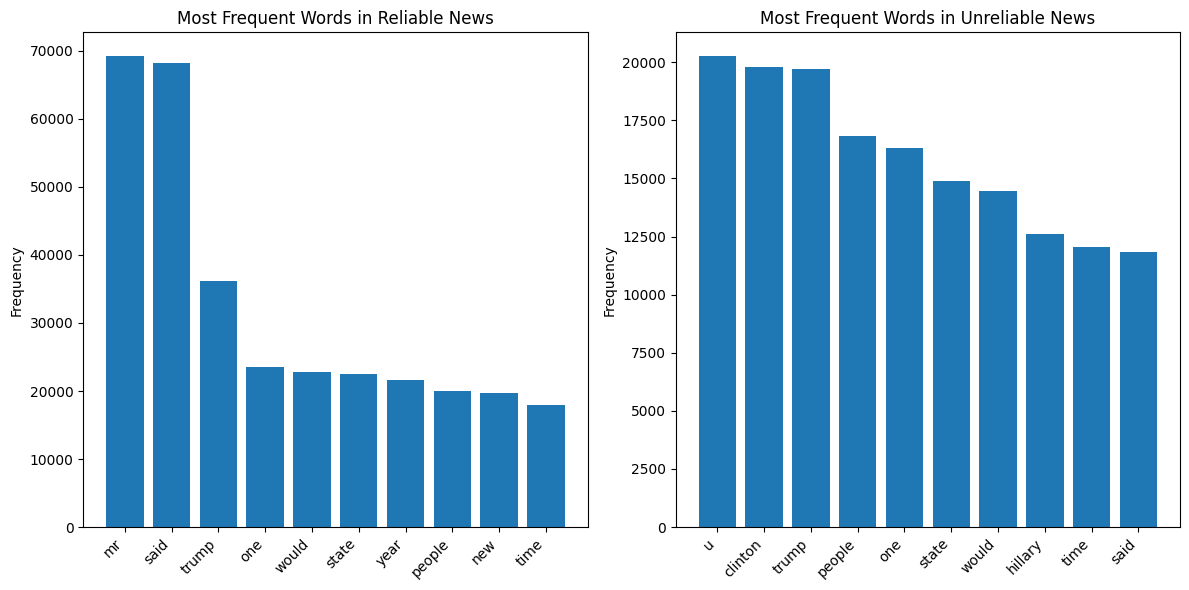

In [ ]:
# prompt: bar plot for Commmon Words in Text

import matplotlib.pyplot as plt

# Assuming 'most_frequent_reliable' and 'most_frequent_unreliable' are already defined
# ... (Your previous code to calculate most_frequent_reliable and most_frequent_unreliable)

# Extract words and counts for reliable news
words_reliable = [word for word, count in most_frequent_reliable]
counts_reliable = [count for word, count in most_frequent_reliable]

# Extract words and counts for unreliable news
words_unreliable = [word for word, count in most_frequent_unreliable]
counts_unreliable = [count for word, count in most_frequent_unreliable]


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(words_reliable, counts_reliable)
plt.title('Most Frequent Words in Reliable News')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.bar(words_unreliable, counts_unreliable)
plt.title('Most Frequent Words in Unreliable News')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [ ]:
def remove_freqwords(text, freq_words):
    """custom function to remove the frequent words"""
    words = text.split()
    filtered_words = [word for word in words if word not in freq_words]
    return ' '.join(filtered_words)

# Assuming most_frequent_reliable and most_frequent_unreliable are already calculated
# Combine frequent words from both lists
freq_words = [word for word, count in most_frequent_reliable + most_frequent_unreliable]

# Now apply the function
dt["wo_stopfreq"] = dt["no_sw"].apply(lambda text: remove_freqwords(text, freq_words))
dt.head()

title  \
0  house dem aide didnt even see comeys letter ja...   
1   flynn hillary clinton big woman campus breitbart   
2                              truth might get fired   
3   15 civilian killed single u airstrike identified   
4  iranian woman jailed fictional unpublished sto...   

                                                text  label  \
0  house dem aide didnt even see comeys letter ja...      1   
1  ever get feeling life circle roundabout rather...      0   
2  truth might get fired october 29 2016 tension ...      1   
3  video 15 civilian killed single u airstrike id...      1   
4  print iranian woman sentenced six year prison ...      1   

                                               no_sw  \
0  house dem aide didnt even see comeys letter ja...   
1  ever get feeling life circle roundabout rather...   
2  truth might get fired october 29 2016 tension ...   
3  video 15 civilian killed single u airstrike id...   
4  print iranian woman sentenced six year prison ...   

                                         wo_stopfreq  
0  house dem aide didnt even see comeys letter ja...  
1  ever get feeling life circle roundabout rather...  
2  truth might get fired october 29 2016 tension ...  
3  video 15 civilian killed single airstrike iden...  
4  print iranian woman sentenced six prison iran ...

In [ ]:
dt['no_sw'].loc[5]

'trying time jackie mason voice reason week exclusive clip breitbart news jackie discus looming threat north korea explains president donald trump could win support hollywood left u need strike first decides bomb whole country behind everybody realize choice thing jackie say except hollywood left theyll get nauseous trump could win left theyll fall love minute bombed better reason jackie explains like transgender toilet jackie also say surprise hollywood celebrity didnt support trump strike syrian airfield month infuriated say might save life doesnt mean anything saved environment climate change theyd happiest people world still jackie say got nothing hollywood celebs theyve got tough life country watch jackies latest clip follow daniel nussbaum twitter dznussbaum'

In [ ]:
dt['wo_stopfreq'].loc[5]

'trying jackie mason voice reason week exclusive clip breitbart news jackie discus looming threat north korea explains president donald could win support hollywood left need strike first decides bomb whole country behind everybody realize choice thing jackie say except hollywood left theyll get nauseous could win left theyll fall love minute bombed better reason jackie explains like transgender toilet jackie also say surprise hollywood celebrity didnt support strike syrian airfield month infuriated say might save life doesnt mean anything saved environment climate change theyd happiest world still jackie say got nothing hollywood celebs theyve got tough life country watch jackies latest clip follow daniel nussbaum twitter dznussbaum'

In [ ]:
import nltk

nltk.download('wordnet')

#lemmatatization
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()

dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(wordnet_lem.lemmatize)
dt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


title  \
0      house dem aide didnt even see comeys letter ja...   
1       flynn hillary clinton big woman campus breitbart   
2                                  truth might get fired   
3       15 civilian killed single u airstrike identified   
4      iranian woman jailed fictional unpublished sto...   
...                                                  ...   
20795       rapper ti trump poster child white supremacy   
20796    nfl playoff schedule matchup odds new york time   
20797  macys said receive takeover approach hudson ba...   
20798          nato russia hold parallel exercise balkan   
20799                                     keep f35 alive   

                                                    text  label  \
0      house dem aide didnt even see comeys letter ja...      1   
1      ever get feeling life circle roundabout rather...      0   
2      truth might get fired october 29 2016 tension ...      1   
3      video 15 civilian killed single u airstrike id...      1   
4      print iranian woman sentenced six year prison ...      1   
...                                                  ...    ...   
20795  rapper unloaded black celebrity met donald tru...      0   
20796  green bay packer lost washington redskin week ...      0   
20797  macys today grew union several great name amer...      0   
20798  nato russia hold parallel exercise balkan 1102...      1   
20799  david swanson author activist journalist radio...      1   

                                                   no_sw  \
0      house dem aide didnt even see comeys letter ja...   
1      ever get feeling life circle roundabout rather...   
2      truth might get fired october 29 2016 tension ...   
3      video 15 civilian killed single u airstrike id...   
4      print iranian woman sentenced six year prison ...   
...                                                  ...   
20795  rapper unloaded black celebrity met donald tru...   
20796  green bay packer lost washington redskin week ...   
20797  macys today grew union several great name amer...   
20798  nato russia hold parallel exercise balkan 1102...   
20799  david swanson author activist journalist radio...   

                                             wo_stopfreq  \
0      house dem aide didnt even see comeys letter ja...   
1      ever get feeling life circle roundabout rather...   
2      truth might get fired october 29 2016 tension ...   
3      video 15 civilian killed single airstrike iden...   
4      print iranian woman sentenced six prison iran ...   
...                                                  ...   
20795  rapper unloaded black celebrity met donald ele...   
20796  green bay packer lost washington redskin week ...   
20797  macys today grew union several great name amer...   
20798  nato russia hold parallel exercise balkan 1102...   
20799  david swanson author activist journalist radio...   

                                         wo_stopfreq_lem  
0      house dem aide didnt even see comeys letter ja...  
1      ever get feeling life circle roundabout rather...  
2      truth might get fired october 29 2016 tension ...  
3      video 15 civilian killed single airstrike iden...  
4      print iranian woman sentenced six prison iran ...  
...                                                  ...  
20795  rapper unloaded black celebrity met donald ele...  
20796  green bay packer lost washington redskin week ...  
20797  macys today grew union several great name amer...  
20798  nato russia hold parallel exercise balkan 1102...  
20799  david swanson author activist journalist radio...  

[20800 rows x 6 columns]

In [ ]:
# prompt: # create the cleaned data for the train-test split:

# Assuming 'dt' is your DataFrame and you want to prepare it for train-test split
X = dt['wo_stopfreq_lem']  # Use the 'wo_stopfreq_lem' column as your feature
y = dt['label']  # Use the 'label' column as your target

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Now X_train, X_test, y_train, y_test contain the cleaned and prepared data for your model training and evaluation.



In [ ]:
import nltk

# Download the 'punkt' resource
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# Assuming 'dt' is your DataFrame and 'wo_stopfreq_lem' is the column you want to tokenize

dt['tokenized_text'] = dt['wo_stopfreq_lem'].apply(word_tokenize)

print(dt[['wo_stopfreq_lem', 'tokenized_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                     wo_stopfreq_lem  \
0  house dem aide didnt even see comeys letter ja...   
1  ever get feeling life circle roundabout rather...   
2  truth might get fired october 29 2016 tension ...   
3  video 15 civilian killed single airstrike iden...   
4  print iranian woman sentenced six prison iran ...   

                                      tokenized_text  
0  [house, dem, aide, didnt, even, see, comeys, l...  
1  [ever, get, feeling, life, circle, roundabout,...  
2  [truth, might, get, fired, october, 29, 2016, ...  
3  [video, 15, civilian, killed, single, airstrik...  
4  [print, iranian, woman, sentenced, six, prison...  


In [ ]:
# prompt: from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# Assuming 'dt' is your DataFrame and 'wo_stopfreq_lem' is the column containing the text
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(dt['wo_stopfreq_lem'])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# prompt: from sklearn.model_selection import train_test_split
X=text_counts

X_train, X_test, y_train, y_test = train_test_split(text_counts, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


ComplementNB model accuracy is 89.81%
------------------------------------------------
Confusion Matrix:
      0     1
0  2044    88
1   336  1692
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2132
           1       0.95      0.83      0.89      2028

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160



In [ ]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 90.48%
------------------------------------------------
Confusion Matrix:
      0     1
0  2044    88
1   308  1720
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2132
           1       0.95      0.85      0.90      2028

    accuracy                           0.90      4160
   macro avg       0.91      0.90      0.90      4160
weighted avg       0.91      0.90      0.90      4160



In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


BernoulliNB model accuracy = 78.49%
------------------------------------------------
Confusion Matrix:
      0     1
0  1502   630
1   265  1763
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      2132
           1       0.74      0.87      0.80      2028

    accuracy                           0.78      4160
   macro avg       0.79      0.79      0.78      4160
weighted avg       0.79      0.78      0.78      4160



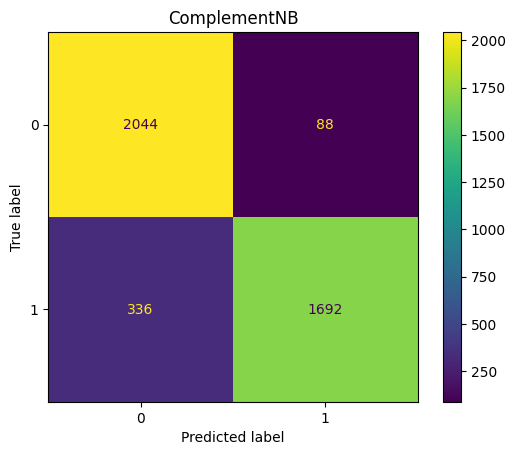

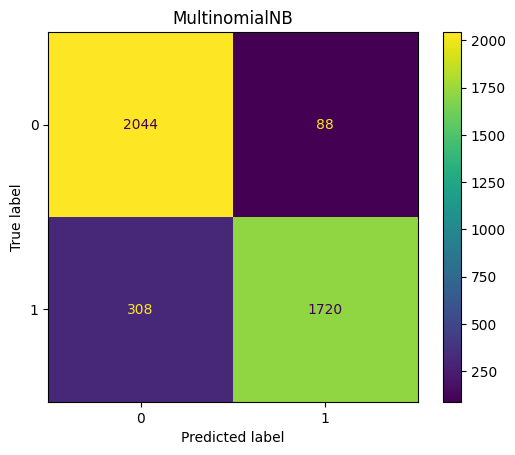

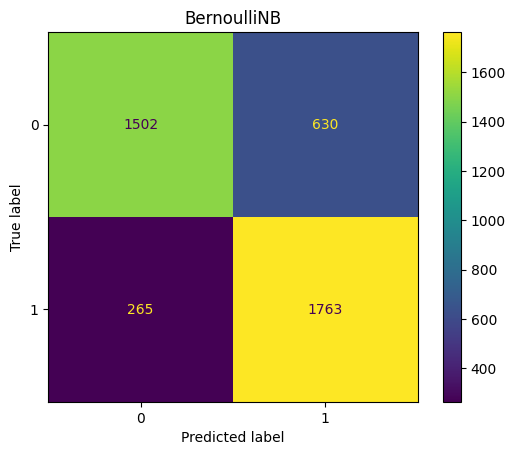

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

k = [CNB, MNB, BNB]
for i in k:
    # Create the ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay.from_estimator(i, X_test, y_test)

    # Set the title
    disp.ax_.set_title(type(i).__name__)

    # Display the plot
    plt.show()

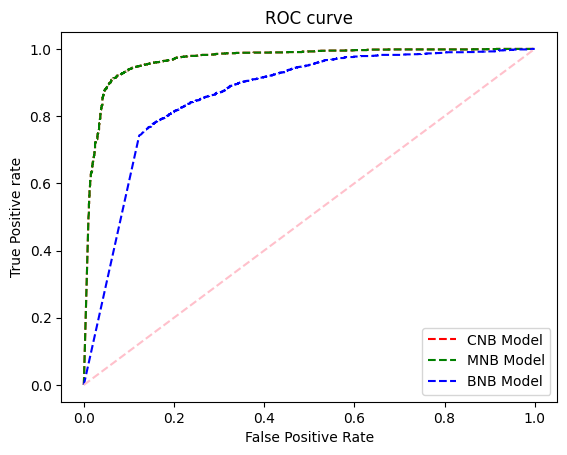

In [ ]:
from sklearn.metrics import roc_curve

# predict probabilities for CNB, MNB, BNB models:
CNB_prob = CNB.predict_proba(X_test)
MNB_prob = MNB.predict_proba(X_test)
BNB_prob = BNB.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();